In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import math
import itertools
from collections import defaultdict
from operator import itemgetter

import torch
import pandas as pd
# import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import normalize
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm

from phoneme_lm import PhonemeLM, build_data_loader, build_vocab, encode_pronunciation
from utils import load_data, split_data

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## Training the Model ##

In [4]:
df = load_data(True)
len(df)

124996

In [5]:
phoneme_to_idx, idx_to_phoneme = build_vocab(df.pronunciation.values)
df['phoneme_ids'] = df.pronunciation.apply(lambda pronunciation: encode_pronunciation(pronunciation, phoneme_to_idx))

In [6]:
df['pronunciation_string'] = df.pronunciation.apply(' '.join)
df['length'] = df.pronunciation.apply(len)

In [7]:
train_df, dev_df, test_df = split_data(df, dev_proportion=.2, test_proportion=.01)
len(train_df), len(dev_df), len(test_df)

(98746, 25000, 1250)

In [9]:
%%time

lm = PhonemeLM(
    phoneme_to_idx, device='cuda', rnn_type='gru',
    embedding_dimension=20, hidden_dimension=10, num_layers=1,
    max_epochs=2000, early_stopping_rounds=5,
    lr=5e-3, batch_size=2**15
)


lm.fit(train_df.pronunciation, dev_df.pronunciation)

Epoch 1: train loss: 3.9496	assess loss: 4.0055
	 AA2 AY1 N AW0 <W> W AA2 AA2 AH1 OW2 UH1
	 OW0 OY2 Y AY2 IY2 ZH AY1 D IH2 Z P
	 IY2 TH F AH1 UH0 IH1 IY0 N EY1 UW OW1
	 AA1 AO0 SH W NG AY2 AW2 AH0 UH1 W P
	 ER1 G EY1 AE0 IY1 EH1 OW0 K UW1 <PAD> SH
Epoch 2: train loss: 3.4639	assess loss: 3.6099
	 </W> N AY1 OY2 OW0 AH0 OY1 ER0 AE2 ER1 EY1
	 UW1 SH DH AO2 AO0 AO0
	 DH IY1 UH0 AA1 AE0 AA2 DH D EY1 G SH
	 IY2 Y JH D AH1
	 AH1 IH1 W OW0 Z K OW1 N AW0 OY2 UH1
Epoch 3: train loss: 3.1007	assess loss: 3.3080
	 N <W> AO2 CH EY1 HH OW2 AO0 AA1 UW1 IY2
	 D ER2 EH1 OY1 AE0 DH IY2 ZH N UH1 EY1
	 Y AW1 UH1 AO1 P V F S V ZH AH1
	 AO0 F AO2 D V OW0 UW OY1 T ZH T
	 ER2 AW0 V AA2 IY2 UW2 EH1 IH0 AH2 JH K
Epoch 4: train loss: 2.7874	assess loss: 3.0447
	 ER0 AO2 AW0 UW2 SH AO0 UW ER1 <W> AA1 CH
	 ER1 SH T OW2 EY2 ER2 ER1 OY0 CH EH0 AO0
	 IY2 IH0 G EH2 S
	 NG W IY0 N EY0 V IH1 AH1 AE1 IH0 EY1
	 D AO0 AA1 UW2 AW2 AY1 F UW IY1 ER1 AO1
Epoch 5: train loss: 2.4885	assess loss: 2.7880
	 EY0 AW1 UH1 DH OW2 AW2

Epoch 44: train loss: 0.7269	assess loss: 1.1044
	 R N D
	 EH1 L M
	 SH OW1 IH0 N
	 N L IH0 AA1 F IH1 K
	 B AA1 T M UW1 L IH0 NG
Epoch 45: train loss: 0.7151	assess loss: 1.1001
	 AW2 F T EY1 L
	 IH1 F P M AH0 UW0 Z
	 HH UW1 AY2 K
	 OY0 S AE1 T T IH0 B
	 L AA1 F K IY0 IH1 UW
Epoch 46: train loss: 0.7106	assess loss: 1.0961
	 D AY2 IH0 K ER0
	 ER0 D AA0 IH1 S AA2 AH0 S B CH M
	 L UW1 N AH0 T
	 S R IY1 AW0 IH0 AY1 OY2 AW0
	 T AY0 OW1 W T R AH0 N
Epoch 47: train loss: 0.7087	assess loss: 1.0923
	 EH1 S AH0 V AO2 HH
	 AY2 UH1 M R AH2 L EH1 M S AH0 D
	 G K B R AH0 M M
	 V R R IY0
	 OY2 UH2 T S
Epoch 48: train loss: 0.7082	assess loss: 1.0887
	 UW1 N K UW2 L T UW2
	 AO0 R AA1 EY1 L R N NG
	 S V AH0 M AA1 B IH0 F T
	 ZH AH0 OY0 B
	 P T IY1 AH0 N T IY1 T DH R AH0
Epoch 49: train loss: 0.7082	assess loss: 1.0853
	 B AA1 S EH2 S R AH0 N
	 UH2 IH0 T R ER0
	 T R K
	 L R D AY1 L S
	 NG AA1 M R
Epoch 50: train loss: 0.7077	assess loss: 1.0819
	 F EH2 W T AH0 L F T
	 S IY0 ER2 IY0
	 UW N AE0 IH0 S S 

Epoch 96: train loss: 0.6372	assess loss: 0.9887
	 P M R EY1 G AH0 S
	 R IY1 L IY0
	 Z EY0 R L EH2 L R Z AH0 D OW0
	 SH AY1 T UH2 B IY0
	 NG HH EH1 N IH0 S L AH0 N
Epoch 97: train loss: 0.6410	assess loss: 0.9875
	 S ER0 EH1 M AH0 R IY0
	 OW2 B UW0 CH OY1
	 V B B UW1 L K EH0 D
	 AH1 T AH0 JH AO2 S
	 G R V EH1 S AH0 N
Epoch 98: train loss: 0.6401	assess loss: 0.9864
	 HH ER0 AA1 T AA2 AH0 L IY0
	 IH1 L UW IY0
	 T ER1 K S
	 UW0 HH K TH R UW0 S K T EH1 K
	 K AA1 K S V AY2 S T
Epoch 99: train loss: 0.6377	assess loss: 0.9852
	 R AE1 F
	 M IY0 S AH0 B IY2 M ER0
	 R IH1 Y OW0 NG Z
	 ER0 OW0 EY1 HH M UH1 T
	 R AW2 L AE1 L ER0 AH0 AO0 V AY1 JH
Epoch 100: train loss: 0.6353	assess loss: 0.9841
	 L AW2 S AH0 K K R OW1 N L
	 S AW0 P D IY0 L AA1 K ER0
	 N F IH1 S AO1 S
	 L EY1
	 L AE1 G D IY0
Epoch 101: train loss: 0.6304	assess loss: 0.9830
	 UW2 TH AA1 B OW0 Z
	 SH OW2 UW1 M AH0 N
	 F IY1 IH0 D
	 G EH1 S Z
	 V Z OW1 T L IY0
Epoch 102: train loss: 0.6316	assess loss: 0.9819
	 HH Z IH1 G JH
	 TH W

Epoch 149: train loss: 0.6037	assess loss: 0.9418
	 OW1 N IH0 S
	 M IH1 N S
	 R AH0 N G <W> AW1 D IH0 N D AH0
	 M EY2 SH AH0 AA1 S T AH0 L
	 K R EH1 L IH0
Epoch 150: train loss: 0.6082	assess loss: 0.9412
	 K EH2 N OW1 K AH0 Z
	 K EH1 K IH0 NG
	 D UW CH AH0 L AA1 B R IY0 AH0 K
	 L AH1 L T
	 B L AA1 V IH0 N
Epoch 151: train loss: 0.6094	assess loss: 0.9406
	 L AY1 K K AH0 G
	 HH IH1 N P AH0 NG
	 S IH1 R D AH0
	 P AH0 N EY1 V AH0 S
	 P R EH1 R AH0 L AH0 L IH0 SH
Epoch 152: train loss: 0.6107	assess loss: 0.9398
	 M AA1 S S T OW2 AO0 S
	 CH AE1 S M IY0
	 HH IY0 HH R EH1 L IY0
	 G EH1 F L AY2 IH0 D
	 R HH AA1 R T IH0 NG
Epoch 153: train loss: 0.6078	assess loss: 0.9391
	 SH AE1 N IH0 Z
	 P SH EH1 M AH0 P ER0
	 G AA0 T AA1 R AE2 N S
	 S T AO1 D AH0 L Z AY2 N
	 IH1 L AH0 S
Epoch 154: train loss: 0.6104	assess loss: 0.9385
	 W IH0 N T AE1 N EH1 N K AH0 M
	 G AW2 R AE1 Z
	 IH0 G AA1 N Z T
	 P AY0 HH IH1 M ER0
	 ER0 L IH1 M AH0 L IH0 N
Epoch 155: train loss: 0.6049	assess loss: 0.9378
	 F W IH1

Epoch 203: train loss: 0.5982	assess loss: 0.9170
	 S EH1 K S T
	 N EY1 K ER0
	 B AE1 N T M OW0
	 T W EH1 Y N HH AE0 N
	 W AA0 L AA1 UW2 D Z
Epoch 204: train loss: 0.5944	assess loss: 0.9167
	 AH0 M IH0 N D EH1 N T IH0 S AH0
	 UW1 SH AH0 N
	 S EH1 N T IH0 CH N
	 B AE1 K JH OW0
	 B IH1 R AH0 S IH0 F R IH0 D
Epoch 205: train loss: 0.5905	assess loss: 0.9164
	 L IH1 N
	 B OW1 L Z P S AH0 UH2 JH
	 M OW1 L IH0 D
	 T AH1 D S AH0 N
	 K R EH1 K T
Epoch 206: train loss: 0.5929	assess loss: 0.9161
	 K R IY1 Z
	 EH1 L N IH0 AO0 K
	 N K Y IH0 NG L T
	 N EY1 D
	 W IY1 V UW0 M B AA2 R N IY0
Epoch 207: train loss: 0.5909	assess loss: 0.9159
	 SH IH0 OW1 D EY2 N IY0
	 K AH1 Z
	 V IH1 S AH0 L
	 HH AE2 T HH AE1 ER0 IH0 M K EH2 N
	 F AE1 N T IH0 S
Epoch 208: train loss: 0.5928	assess loss: 0.9156
	 D IH1 N IY0 UH1 K R ER0
	 AH0 M AH0 AW0 S AE1 L IY0
	 IY0 EH2 G AA1 L AH0 N D
	 S ER0 EY1
	 OW0 JH IH0 N K EH1 R T IY0 S
Epoch 209: train loss: 0.5904	assess loss: 0.9153
	 F AA0 N S EH1 D IH0 NG AH0
	 W IY1 S

Epoch 257: train loss: 0.5840	assess loss: 0.9060
	 R EH1 R IY0
	 S K OW1 L AH0 T
	 N EH1 Z IH0 K
	 W EH1 R S D ER0
	 K EH1 N T AH0 Z
Epoch 258: train loss: 0.5844	assess loss: 0.9057
	 D EH1 Z IY0
	 K UH1 T K ER0
	 NG EH1 TH
	 G AA0 N T R EH1 K AH0 T
	 HH IH1 S OY1
Epoch 259: train loss: 0.5863	assess loss: 0.9056
	 T AH1 L K IH0 N
	 F AA1 N OW0 Z
	 D IH1 N K Y AH0 N
	 K AW1 N EH1 K L IY0
	 S S T R AA1 N IH0 NG K IY0
Epoch 260: train loss: 0.5831	assess loss: 0.9054
	 M IH1 T EH0 N
	 T AW0 G IY1 Z N ER0
	 CH ER1 L AA0 S P
	 K UH2 P IY1 K Z
	 T IY1 N G AH0 N S IH0 K
Epoch 261: train loss: 0.5851	assess loss: 0.9053
	 D AO1 R D L AY0 T
	 N AA1 L D ER0 Z
	 M AY1 L D IY0
	 CH AE1 M AH0 SH
	 P ER1 N D
Epoch 262: train loss: 0.5827	assess loss: 0.9052
	 L IY1 T IY0 P ER0 G AH0
	 K EH1 G IH0 D
	 W IY0 B R AA1 R OW0
	 W AE1 T
	 M UW1 N IY0
Epoch 263: train loss: 0.5860	assess loss: 0.9050
	 SH UH0 AE1 NG S M AH0 Z AH0
	 K AH0 R P IH1 F R AH0 N
	 M AE1 M S Y OW0 Z
	 L S P AY1 P IH0 Z S
	 K AE2

Epoch 312: train loss: 0.5800	assess loss: 0.8986
	 F AY0 P IY1 IH2 V S
	 K R AE1 K D AH0 L T
	 Y ER1 IH0 NG
	 N AA0 P AE1 K AH0 T EY2 IH0 NG
	 S JH EH1 T AE1 N
Epoch 313: train loss: 0.5812	assess loss: 0.8985
	 JH IY1 L
	 G AA1 L M AH0 N
	 IH0 F AH0 G AW1 Z
	 IH2 R IY1 N M ER0
	 AO1 V IH0 S
Epoch 314: train loss: 0.5783	assess loss: 0.8984
	 L AH1
	 AA0 F IH0 B EY2 K
	 SH AY1 T AY2 N
	 R AY2 EH1 P OW2 JH IY0
	 S W AA1 N P ER0
Epoch 315: train loss: 0.5792	assess loss: 0.8984
	 S P IH2 N S N OW1 N ER0 K ER0
	 S K AE1 CH AH0 N
	 IH0 M AO1 L AH0 V
	 N EY1 Z OW0
	 AH0 IH1 N K ER0 P ER0
Epoch 316: train loss: 0.5811	assess loss: 0.8982
	 S L IY1 T AA2 L S
	 L AE1 N K
	 S AY1 ER0
	 L AH0 V IH1 F IY0
	 TH AO1 R K
Epoch 317: train loss: 0.5809	assess loss: 0.8982
	 B AO2 D AA1 L OY2
	 K AA1 R ER0
	 T R AE1 V ER0 IH0 SH
	 D AA1 S T S
	 W AO1 N Z
Epoch 318: train loss: 0.5830	assess loss: 0.8980
	 HH IY0 S IY1 D AH0 Z
	 D AE1 S IH0
	 T EY1 SH AH0
	 R IH0 P EH1 T T AH0 N
	 T R AH1 N D AH0
Epoch

Epoch 367: train loss: 0.5784	assess loss: 0.8935
	 M AH1 L IY0
	 B ER2 M EH1 N AH0
	 L AE1 R AH0 N S D
	 L UW1 IH0 K
	 M AE1 K D W AH0 L
Epoch 368: train loss: 0.5790	assess loss: 0.8935
	 D AA0 N D AO1 P AO2 S Z
	 HH EH1 R AH0 D EY1 HH <PAD> <PAD> <PAD> <PAD>
	 EH1 R T IY0 ER0
	 T R AE1 L K EY2 T
	 B R AE1 L B AY2 N
Epoch 369: train loss: 0.5743	assess loss: 0.8934
	 AH0 N AY1 K IH0 T
	 T S P AW1 S T IH0 N
	 M AA1 L SH AH0 N AH0 N
	 F AE1
	 HH AH1 R AE2 V
Epoch 370: train loss: 0.5786	assess loss: 0.8933
	 D R AE1 Z S AH0 P IY0 ER0
	 HH AE1 D EY0 T
	 D OW1
	 S IH1 N P ER0
	 T EH1 R AH0 JH IH0 G
Epoch 371: train loss: 0.5757	assess loss: 0.8933
	 K EH2 M UW2 F R IH1 N SH AH0 T
	 R AH0 S T IY2 L IH0 D EH1 T S
	 B EH1 F T AH0 D
	 K AO2 R M AH0 N OW1 D AW0 AA0 NG
	 N IH1 B OW0 L EY2 T
Epoch 372: train loss: 0.5753	assess loss: 0.8932
	 B OW0 S IY1 P AH0 L
	 R AE1 S T AH0 D
	 L EH1 L IY0 ER0
	 L AW1 S T AO0 NG N
	 D AH1 F
Epoch 373: train loss: 0.5798	assess loss: 0.8931
	 F R AE1 T AH0 L

Epoch 421: train loss: 0.5767	assess loss: 0.8898
	 L EH1 N D ER0 Z IH0 S T
	 AE1 B S OW2 F AY2 V
	 AH0 T ER0 Z AA1 D IH0 S N
	 OW0 K AO2 R M AA1 L
	 L EH1 M
Epoch 422: train loss: 0.5785	assess loss: 0.8898
	 S AE1 N W AH0 N
	 K R EH1 N K AH0 S T
	 S AE1 L AA0 N <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
	 AH1 N D IY0 ER0
	 IH1 N F AH0 N OW0
Epoch 423: train loss: 0.5714	assess loss: 0.8897
	 M AA1 K K IH0 M K R IY0
	 R IH1 L T AE2 N
	 B AO1 R L IH0 Z
	 K R EH1 L M EY2 L OW0
	 HH AA1 R B ER0 Z
Epoch 424: train loss: 0.5771	assess loss: 0.8897
	 G ER1 K AH0 D K AH0 N
	 F IH1 N Z IH0 NG OW0
	 M D W AH0 S AA1 S G R IY0
	 K EH1 S T R AO0 S M IH0 Z
	 K M AY1 D ER0 K
Epoch 425: train loss: 0.5740	assess loss: 0.8896
	 K AE1 L AH0 T IY0 D
	 D IY1 M AH0 B L IY0
	 M AH0 T L EY1 DH AO2 F AH0
	 G IH1 T AH0 S T IY0
	 R EH1 N AH0 T
Epoch 426: train loss: 0.5753	assess loss: 0.8894
	 T IY0 EH1 N
	 K R EH1 F ER0 N Z
	 AH0 M EH1 N S AH0 D
	 T AE1 S AH0
	 T ER1 B ER0 D
Epoch 427: train loss: 0.5746	assess lo

Epoch 475: train loss: 0.5765	assess loss: 0.8870
	 W AE1 SH AH0 N
	 F AH0 N IH1 M
	 Z OY1 L IY0 D
	 B AA1 D P R IY0
	 K L EY1 M
Epoch 476: train loss: 0.5714	assess loss: 0.8870
	 B AW1 N F L OW2 B IY0
	 Y AE1 F ER0 OW0
	 F R AA1
	 S T AA1 V AH0 L
	 G R EY1 N D IH0 NG
Epoch 477: train loss: 0.5757	assess loss: 0.8869
	 S N L TH ER1
	 B AE1 TH P Y OY1
	 JH AH0 B AA1 K AH0 Z
	 AA1 L P UW1 AH0 Z
	 CH AO1 R AH0 B IH0 L S
Epoch 478: train loss: 0.5709	assess loss: 0.8868
	 UH0 S AY2 R K UH1 R IH0 NG
	 N OW1 S
	 P AE1 N IH0 NG M IH0 T
	 F L AE1 G IH0 K EY2 T R
	 P AA1 CH Y AH0
Epoch 479: train loss: 0.5720	assess loss: 0.8867
	 S OW1 D AH0 T
	 R OW1 N AH0 L IY0
	 OW0 S P W Y UW1 ER0 AH0 N
	 AH0 N K AH0 N V AW1 T EH0 Z T
	 M AH0 M F R AH1 L ER0
Epoch 480: train loss: 0.5743	assess loss: 0.8868
	 T AY1 N IH0 K
	 K W AE1 N S AH0 L IH0 NG
	 D ER1 M B R IH0 T
	 G EY1 N F IY0
	 AA1 L M SH ER0 Z
Epoch 481: train loss: 0.5709	assess loss: 0.8867
	 S OW0 S IY1 S T L IY0
	 HH IY1 D AH0 Z
	 AY1 N Y <P

Epoch 529: train loss: 0.5732	assess loss: 0.8847
	 N AH1 JH T UW0
	 D R IH1 G D
	 SH IY1 N AH0 M AH0
	 K AA1 R D
	 ER1 N AH0 L IY0
Epoch 530: train loss: 0.5717	assess loss: 0.8848
	 AH0 R IH1 M K IY0 W ER0
	 F L AE1 G D
	 P EH1 N IH0 D Y AA1 L D
	 Z UW1 AH0 T EY2 T
	 W UW1 W AH0 N D ER0 Z
Epoch 531: train loss: 0.5698	assess loss: 0.8846
	 S EH1 S OW0 F EY0 T
	 HH L IY1 N S
	 AA2 S T IY0 L AY1
	 M IH0 AA1 NG JH AH0 UH2 D
	 IH0 T AH0 B AE1 Y UW1 AH0 N
Epoch 532: train loss: 0.5717	assess loss: 0.8846
	 B UW1 K D AH1 S T
	 EY1 N SH UW0
	 M OW1 L AH0 L
	 S EH1 L CH
	 IY0 IY1 N IH0 NG
Epoch 533: train loss: 0.5700	assess loss: 0.8846
	 B R IH1 SH AH0 N AY1 AH0 N ER0
	 OW1 K IY0 OW0 K ER0 Y <PAD> <PAD> <PAD> <PAD>
	 F IY1 L AH0 K EY2 T S
	 K AA1 N D ER0 B AH0
	 JH AO1 F AH0 K B OW0
Epoch 534: train loss: 0.5734	assess loss: 0.8845
	 K AY1 SH AY2 T L IY0
	 D T AA1 N B IH0 T
	 IH0 N HH AA1 R IH0 D
	 </W>
	 IH2 P AO1 R
Epoch 535: train loss: 0.5708	assess loss: 0.8845
	 L AO1 NG V IH0 N ER0


Epoch 584: train loss: 0.5724	assess loss: 0.8829
	 K IY0 EY1 N AH0 K W AH0 N
	 G AH0 N T AO1 R AH0 T
	 K R IY1 P IH0 V
	 K AO1 R L IY0
	 L UW1 M AH0 T
Epoch 585: train loss: 0.5693	assess loss: 0.8827
	 G R IY0 B EH1 R IH0 K UH0 AH0 N
	 IH1 B AE2 N D
	 K IH1 N T AO0 R T HH AA2 D
	 K AA1 R IH0 F ER0
	 T AE1 N Y OW0
Epoch 586: train loss: 0.5687	assess loss: 0.8827
	 P R AO1 SH AH0 N
	 M IH1 N T OW0
	 AE1 L AH0 D AY2 D
	 R AE1 N D AH0 M
	 L AE1 M AH0 L IY0
Epoch 587: train loss: 0.5685	assess loss: 0.8828
	 V AA1 S S T
	 OW1 SH AH0 M EH2 T IH0 K
	 T AO1 R
	 K AA2 B ER0 B AE1 D D S
	 L EY1 T AH0 L
Epoch 588: train loss: 0.5714	assess loss: 0.8827
	 L EY1 D EH2 D Z
	 G IH1 S AH0 M AH0 B ER0 S
	 HH AE1 L N D ER0
	 OW1 N F IH0 F EY1 T AH0 L
	 AA1 L OW0
Epoch 589: train loss: 0.5692	assess loss: 0.8826
	 HH AE1 T HH AO2 R
	 W AA2 R IH0 M AA0 N G OW2 P AH0
	 EY0 N V AY1 N
	 IH0 K ER0 IY1 Z ER0
	 M IH0 N EH1 R AH0 L IY0 AH0 L
Epoch 590: train loss: 0.5718	assess loss: 0.8825
	 K UW1 Z OW0
	 D 

Epoch 639: train loss: 0.5675	assess loss: 0.8811
	 AH2 D D AA0 T R OY1 SH AH0 N
	 D AH0 P AW1
	 T ER0 M IY1 T AH0
	 S N AE1 N S T IH0 K S
	 IH0 K Z UW1 N AH0 S
Epoch 640: train loss: 0.5668	assess loss: 0.8810
	 P IH1 N S T IY2 W AA0 L S
	 N AA1 D IH0 T
	 G OW1 T S
	 AE2 L P S L AH0 S P ER1 AH1 T
	 W AH0 S OW0 D IH1 K S T AH0 M
Epoch 641: train loss: 0.5665	assess loss: 0.8811
	 S T AH1 N R UH2 L
	 B AY1 R EH0 N
	 R IH0 N AE1 L K AH0 L
	 JH AE1 T L AE2 V
	 R UW1 F M AE2 T S
Epoch 642: train loss: 0.5687	assess loss: 0.8810
	 G AW1
	 CH IH1 N JH
	 HH IY1 ER0
	 F UH1 N D ER0 D
	 JH AA2 N T ER1 L IY0 Z
Epoch 643: train loss: 0.5657	assess loss: 0.8810
	 K AA0 S T EH2 K AA1 G
	 S K R EY1 AH0
	 D EH1 R ER0
	 S T AH1 F IH0 M AH0 N S
	 L AA1 SH AH0 N T S
Epoch 644: train loss: 0.5679	assess loss: 0.8809
	 B EH1 S
	 Y ER0 M AO1 R
	 L IH1 K AH0
	 W EY1 L AH0
	 S AE1 V CH
Epoch 645: train loss: 0.5647	assess loss: 0.8809
	 F IH1 B L IY0
	 G L IY1 Z IY0
	 R IH0 N K IY1 TH IH0 T
	 P AA2 R N AA1 L

Epoch 694: train loss: 0.5665	assess loss: 0.8795
	 TH R IH1 S T IY0
	 AH0 K L IH1 SH IH0 K
	 S S EH1 P IH0 N
	 P EY1
	 CH IH1 SH ER0 Z
Epoch 695: train loss: 0.5714	assess loss: 0.8794
	 M AE0 N S ER1 N
	 S AH1 Z IH0 T
	 M AH0 S AO1 N
	 N AA1 M AH0 N F AH0 L
	 W AH0 K R IH1 N S IY0 Z
Epoch 696: train loss: 0.5677	assess loss: 0.8796
	 K UH1 R EY2 L OW2 N
	 L OW1 AH0 S M
	 HH W OW1 ZH OW0 N
	 L IY1 TH
	 HH IY1 N IY0 AH0 L
Epoch 697: train loss: 0.5670	assess loss: 0.8795
	 M AA1 G AH0
	 B AO0 R S IH0 S AO1 T
	 K ER0 M AE1 B AH0 Z
	 B EH1 W EH2 N T
	 EY1 N S AH0 S
Epoch 698: train loss: 0.5680	assess loss: 0.8794
	 P IH2 N D IH2 N K AH0 N S L
	 P IH2 L OW0 Z EH1 R G AH0 L
	 T AH0 S OW1
	 B R EY1 S
	 B ER1 L AH0 L
Epoch 699: train loss: 0.5693	assess loss: 0.8793
	 HH IH1 NG S IH0 N
	 K IH1 N S IH0 N T
	 G L AE1 L B IH0 S D
	 S L OW1 K AH0 IH0 NG
	 R IH1 P M AH0 N
Epoch 700: train loss: 0.5641	assess loss: 0.8794
	 AH2 L V OW2 D L IY1 V AH0
	 F OY1 S
	 SH AA1 R AH0 V R OW2 Z
	 M EH1 D OW

Epoch 750: train loss: 0.5698	assess loss: 0.8782
	 F AE1 N V IH0 L
	 P EH1 T IH0 B AH0
	 S IH2 M W AA1 N T AH0 B <PAD> <PAD>
	 D AH0 B EY1 T ER0 D
	 G R OW0 D IH1 T
Epoch 751: train loss: 0.5685	assess loss: 0.8782
	 R AA1 K Y AH0 F EY2 K W AH0 N
	 B AA1 L G AH0 N
	 L EH1 K R AH0 W EY2
	 R UH1 D EY2 T IH0 NG
	 ER0 IH1 P AH0 K
Epoch 752: train loss: 0.5655	assess loss: 0.8782
	 D L AE1 M AH0 N IY0
	 B OW1 T AE2 L
	 W AW1 S T ER0 S AH0 N
	 F L IY1 N
	 K AO1 S T IY0
Epoch 753: train loss: 0.5671	assess loss: 0.8781
	 HH AE1 T SH AH0 N
	 K AO2 R D UW1 Z S IY0
	 S T S IH0 S OW0 D IH0 SH EY1 V
	 W AA1 N D OW0
	 F R AE1 T ER0
Epoch 754: train loss: 0.5673	assess loss: 0.8781
	 B IY1 AH0 L OW0
	 AA1 L B ER0 M
	 M OW0 G Z AA1 R L T AH0 N T
	 W ER1 T ER0
	 IH0 R AH1 K S IY0
Epoch 755: train loss: 0.5663	assess loss: 0.8780
	 HH AE1 R Z S
	 B AA1 N B
	 F AO0 R T AA1 M L IY0
	 S K AA1 N HH
	 D AE2 T AH0 K R EY1 T AH0 L
Epoch 756: train loss: 0.5661	assess loss: 0.8778
	 K AO0 R L AO1 N IY0
	 R AA

Epoch 805: train loss: 0.5662	assess loss: 0.8769
	 R EH0 M EH1 M ER0
	 HH EY1 SH AH0
	 P ER1 D AH0 N D
	 S IH0 Z AA0 S N AE1 S AH0 S T
	 M AH0 N TH AA1 N S
Epoch 806: train loss: 0.5641	assess loss: 0.8771
	 T HH UW1 AH2 N T
	 M AH0 K IH1 R D AH0 Z
	 W EH1 NG T IY0
	 F IH0 T EY1 ER0 AH0
	 R B AE1 N JH ER0
Epoch 807: train loss: 0.5630	assess loss: 0.8769
	 K EH1 T B EY0 T
	 M M AH1 N T AH0 N
	 M UW2 L AH0 B IH1 K CH ER0 Z
	 IH0 N R AE1 K S B AH0 G ER0
	 G R IH1 L
Epoch 808: train loss: 0.5641	assess loss: 0.8768
	 P IH1 P IY0
	 B IY2 N OY1 JH AH0 K
	 F EH0 S K L AA1 T
	 P UW1 M AH0 N
	 M AE1 N T ER0 D
Epoch 809: train loss: 0.5637	assess loss: 0.8767
	 W AA1 N S EY2 N
	 AH0 G L IY1 N
	 ER1 S P
	 S AH1 N ER0
	 M AH0 K EY1 TH W IY0
Epoch 810: train loss: 0.5667	assess loss: 0.8768
	 B OY0 L IH0 S IH1 L D IH0 S
	 S EH1 N Z IH0 NG
	 B AE1 S T ER0 V AE2 D D EY2 L
	 OW0 Z AO1 R B AH0 L
	 AE1 T IY1 ER0
Epoch 811: train loss: 0.5657	assess loss: 0.8768
	 R IY0 IH0 M AH1 HH IH0 S
	 D AA1 K T E

Epoch 859: train loss: 0.5596	assess loss: 0.8761
	 V ER1 TH
	 L EH1 L AH0 N T ER0
	 R IY0 AH0 N EY1 K T AA2 R K
	 T AO1 S AH0 L
	 D AH1 N N
Epoch 860: train loss: 0.5683	assess loss: 0.8757
	 R AO1 K IH0 S T
	 TH L AA1 S S IH0 B AH0 S P AH0
	 B R AO1 Z ER0
	 EH2 D IH0 AH0 N AA1 M IY0 M AH0 N
	 S T R IY0 N AH1 N S AH0 D AH0
Epoch 861: train loss: 0.5697	assess loss: 0.8757
	 K AH1 N T L IY0
	 L UW0 M AA1 T EH1 P M ER0
	 Y UW0 P UW1 B L IY0
	 HH AE1 N UW2 T AH0 IH0
	 B R IY2 AH0 D EY1 B AH0 B IY0 N
Epoch 862: train loss: 0.5658	assess loss: 0.8760
	 SH ER1 M IH0 N D R ER0
	 M OW1 P AA2 R Z
	 IH0 K AH0 TH IH1 N F IY0
	 IH1 R AH0
	 JH IY1 T
Epoch 863: train loss: 0.5682	assess loss: 0.8758
	 JH AY1 M P L IH0 SH
	 P R AE1 N T IH0 NG
	 K Y UW1 F S
	 L EH1 L G OW2 S
	 S EY1 S
Epoch 864: train loss: 0.5666	assess loss: 0.8756
	 M EH2 S P AH0 F EH1 S T IH0 N
	 S EH1 S IH0 D IH0 NG
	 R EY1 Z
	 EY1 SH OW0
	 IY0 JH W EY1 G AH0 N
Epoch 865: train loss: 0.5657	assess loss: 0.8759
	 M IH0 K AA0 IH1 

Epoch 913: train loss: 0.5632	assess loss: 0.8750
	 F AO1 K OW2 L IH0 T
	 G AE1 N EH0 T IY0
	 TH AW1 L IH0 NG
	 HH IH1 K L W AH0 N
	 B AY1 Z IH0 NG
Epoch 914: train loss: 0.5659	assess loss: 0.8750
	 AH0 K EH1 L IY0
	 L EH1 T AH0 HH EY2 Z
	 P IH1 P ER0 D
	 M AH0 T R IH1 N IY0 AH0 N IY0
	 K AA1 L K AH0 K
Epoch 915: train loss: 0.5651	assess loss: 0.8749
	 B AW1 N IY0
	 AE1 T L AY0 IH0
	 B IH0 S K L AY1 Z
	 D AH0 S T AA1 R M AH0 N
	 B UW1 L IY0
Epoch 916: train loss: 0.5639	assess loss: 0.8749
	 P IH1 R AE0 T D
	 K R AO1 K S T ER0
	 S AE1 N S T IY0
	 S IY1 T IY0 Z
	 W IH1 B ER0
Epoch 917: train loss: 0.5683	assess loss: 0.8748
	 K AE1 S AH0 T
	 M AY1
	 P AA0 R JH AH0 N AH0 M EH1 L
	 AH0 M IH1 K
	 R AE0 L EY1 K T ER0
Epoch 918: train loss: 0.5631	assess loss: 0.8749
	 S AH1 SH AH0 N
	 AO1 T Z
	 IY0 D IH0 L EH1 Z AH0 T
	 EH1 V AH0 L
	 F R AO1 T OW2 G ER0 D
Epoch 919: train loss: 0.5640	assess loss: 0.8748
	 D ER1 D L ER0
	 IH1 B P R UH2 D
	 T R AE1 N IH0 S ER0
	 S IH1 R K IH0 NG
	 L IH1 V 

Epoch 968: train loss: 0.5646	assess loss: 0.8742
	 IH0 N T R AY1 OW2 Z
	 B AA1 P S K IY0
	 T R EH1 K R OW0 V AH0 S
	 F IY1 T AH0 T
	 TH IH1 D AH0 N
Epoch 969: train loss: 0.5670	assess loss: 0.8743
	 D AE1 K
	 M AH0 F EY1 V
	 K AA0 S T EH1 F AH0 S
	 Z AE1 TH Y ER0 OW2
	 CH EH1 S T IH0 NG IH0 S
Epoch 970: train loss: 0.5639	assess loss: 0.8742
	 L OW1 B EH2 R AH0 N
	 R AA1 T B ER0 N IH0 NG
	 R EH1 S K ER0
	 SH AA1 N D
	 W AA1 S T R IY0 AO2 K
Epoch 971: train loss: 0.5615	assess loss: 0.8742
	 T AA0 D R AA1 K AY2 Z T ER0
	 K L AH1 NG T AH0
	 CH EH1 L IH0 NG
	 AA2 P B ER0 TH AO1 R T ER0
	 AA1 L P OW0
Epoch 972: train loss: 0.5629	assess loss: 0.8741
	 Y UW1 L Y UW0 IY0
	 V AH0 B UW1 M IY0
	 B AE1 G T AH0 M AE2 L IH0 N
	 M AE1 P AH0 L T IH0 NG
	 R AH0 K AH1 P S T AY0
Epoch 973: train loss: 0.5646	assess loss: 0.8739
	 M AH0 D IH1 N AH0 S B IY2 Z
	 TH AH1 NG D ER0
	 N EY1 D AH0 N
	 W AE2 V AA2 R OW0 G R IY1 T AH0
	 W EY1 K IH0 T EY2 T
Epoch 974: train loss: 0.5607	assess loss: 0.8740
	 SH 

Epoch 1024: train loss: 0.5651	assess loss: 0.8733
	 B ER1 S K AH0
	 D AY1 SH ER0
	 M AH0 K AE1 R AH0 L IY0
	 V ER0 AE1 S T IH0 D
	 G EH1 R IH0 NG IY0
Epoch 1025: train loss: 0.5668	assess loss: 0.8735
	 N IH1 N S
	 M AH0 Z IH1 R IY0
	 S EH1 Z
	 S R AO1 R IY0 AH0
	 IH0 N D AH0 N AO1 R T IH0 K
Epoch 1026: train loss: 0.5651	assess loss: 0.8733
	 G ER1 N R AH0 L
	 S AO1 G ER0 D
	 JH AE1 M AH0 N
	 AA2 P AH0 N EH1 K K AH0
	 R AE2 N W EY1 Z F EY2
Epoch 1027: train loss: 0.5671	assess loss: 0.8733
	 Y UW1 AW0 T
	 R AA1 T IH0 NG
	 S AH0 N AE1 S AH0 Z
	 R AO1 R K Y OW0
	 K AA1 G L ER0 Z
Epoch 1028: train loss: 0.5619	assess loss: 0.8733
	 S B OW2 V IH0 V IY1 T ER0
	 G AW1 S AH0 T
	 EH1 CH AH0 N
	 R AA1 G ER0 IY0
	 S K IH1 L V IH0 N
Epoch 1029: train loss: 0.5670	assess loss: 0.8732
	 G L AA1 B AH0 L IH0 NG
	 W IH1 N S K ER0
	 K EY1 T ER0 IH0 NG
	 F AH0 T EH1 N T
	 M IH0 S R AE1 M OW0
Epoch 1030: train loss: 0.5643	assess loss: 0.8733
	 HH AE2 L AA1 N ER0
	 P IH1 B ER0
	 D EH1 G OW0
	 SH AE1 R 

Epoch 1079: train loss: 0.5607	assess loss: 0.8723
	 AY1 K
	 F IH1 NG JH AH0 Z
	 AE1 K ER0 IY0
	 M AA1 L AH0 G UH0 R AY2 Z T AY2
	 K P AO1 R
Epoch 1080: train loss: 0.5605	assess loss: 0.8724
	 M IH1 L IH0 K
	 B AH1 D IH0 D T AH0 T IY0 EY2 F
	 S L AO1 T R AH0 V
	 AE1 K R OW0 S IH2 L K IY0
	 R IY0 G AA1 R G AH0 N K
Epoch 1081: train loss: 0.5633	assess loss: 0.8724
	 K W EH1 N AH0 M AA2 R T IH0 NG
	 S K L EH1 L S AH0 L Z
	 F IH1 L D IY0
	 K W AH1 M AH0 L
	 T AE1 N S AH0 G
Epoch 1082: train loss: 0.5626	assess loss: 0.8726
	 R AA1 R Z IY0
	 R OW1 S IH0 JH T
	 CH AE1 T ER0
	 S IY1 P AH0 L AH0
	 S AO2 K OW0 K UW1 CH AH0 L T
Epoch 1083: train loss: 0.5639	assess loss: 0.8725
	 K AA0 R AA1 G L D
	 SH UW2 N R AO1 R G AO2 R CH AH0
	 P R OW1 G AH0 F IH0 NG
	 S W IH1 S T IH0 N
	 JH EY1
Epoch 1084: train loss: 0.5673	assess loss: 0.8726
	 B AE1 K IH0 T
	 P R AA1 B AH0 D
	 AA2 V ER1 S T ER0 ER0
	 R AH0 S EY1 N
	 K L AA1 B AH0 M IY0
Epoch 1085: train loss: 0.5620	assess loss: 0.8724
	 F UW0 AE1 N S

Epoch 1133: train loss: 0.5607	assess loss: 0.8718
	 P L AO1 R TH
	 HH R IY1 G
	 Y AH0 F W IY1 L ER0
	 F OW1 M P AO2 R D
	 HH IH1 S
Epoch 1134: train loss: 0.5636	assess loss: 0.8719
	 S OW1 S T S ER0 D EH2 S
	 K R AH0 K IY1
	 G R EH1 L IY0 Z
	 P R IY1 N
	 P IH1 N T IH0 K
Epoch 1135: train loss: 0.5599	assess loss: 0.8718
	 AE0 K M AH0 HH AE1 N ER0
	 P AO2 L EH1 R IH0 N AH0 L
	 N OW1 D IH0 NG
	 B EH1 P ER0
	 K UW1 K AO2 R F
Epoch 1136: train loss: 0.5657	assess loss: 0.8718
	 M AH0 K AA1 L HH AE2 K
	 M IH1 L IH0 K N
	 R AY1 K OW0 IH0 D
	 HH ER1 S T IH0 Z
	 B AA1 N B Y OY0
Epoch 1137: train loss: 0.5593	assess loss: 0.8721
	 R IY2 M EY1 D IY0
	 S IY1 D EH2 AE2 K
	 AA0 JH EH1 L IH0 T R
	 Z AO1 R Z
	 R IH0 TH EH1 L IH0 T
Epoch 1138: train loss: 0.5644	assess loss: 0.8720
	 D EH1 R AH0 N D
	 T R AH1 L AH0 L IH0 NG
	 AH0 N T IH1 JH ER0
	 S AA1 CH D IH0 T
	 V OY1 D AH0 M
Epoch 1139: train loss: 0.5630	assess loss: 0.8719
	 S K AA1 R M HH AY2 TH
	 SH ER1 V AH0 B ER0 Z
	 JH IY1 B ER0
	 F UH1 T

Epoch 1188: train loss: 0.5613	assess loss: 0.8712
	 P AA1 S OW0
	 R AH0 G AE1 NG IH0 K
	 AH0 N OW1 L OW0
	 AH0 K N EY1 V HH ER0 K
	 M OW1 L ER0 Z
Epoch 1189: train loss: 0.5651	assess loss: 0.8713
	 AO0 B AE1 N D B OW2 V IH2 T M
	 D IY0 S IH0 K IH1 D IH0 T S EY2
	 S AA1 R
	 F AA2 N F IH1 S T IH0 NG K AH0
	 OW1 T AH0 L Z
Epoch 1190: train loss: 0.5634	assess loss: 0.8712
	 F B AE1 L T W AH0 B EH2 N
	 M EH1 S M IY0
	 AH0 D AO0 R AA1 L B IY0 AH0 L UW2
	 SH AO1 L Z EY2 T
	 N IH0 S AH0 NG P L AO1 L
Epoch 1191: train loss: 0.5660	assess loss: 0.8712
	 T Y AO1 L D AH0 L
	 W AA1 N D AH0 N
	 F UW1 L IY0 AH0 T
	 M AY1 SH
	 B AA1 N Z IH0 NG
Epoch 1192: train loss: 0.5596	assess loss: 0.8711
	 S IY1 B OW0 K AH0
	 F L AE1 N T AW2 L
	 V IH2 S OW2 S M IH1 N SH AH0 N
	 CH IY1 T ER0 Z
	 L EH1 D L ER0 Z
Epoch 1193: train loss: 0.5605	assess loss: 0.8711
	 S P AA0 G AE1 K IH0 T
	 P EH1 R AH0 D L AY1 Z
	 B AH0 L EY1 SH AH0 N
	 M OW2 T R IY0 IY1 ER0
	 AA0 L B AA1 S IY0
Epoch 1194: train loss: 0.5636	asses

Epoch 1243: train loss: 0.5627	assess loss: 0.8706
	 S AY1 S
	 K L AY1 D T ER2 K IY0
	 D IH0 K AE1 L T AH0 L
	 S AH0 N Z Z P IH2 M IY0 AE1 G
	 IH1 F B W
Epoch 1244: train loss: 0.5572	assess loss: 0.8709
	 K IY1 S IH0 Z
	 R AH0 S EY1 L IH0 K
	 B EH1 R ER0 AA0 R L IH0 NG
	 S T OW0 S IH1 D AH0
	 AH0 S IY1 L
Epoch 1245: train loss: 0.5601	assess loss: 0.8707
	 K IH1 G R AH0 D
	 F AA1 R IY0 AH0 N D
	 JH UW1 P
	 P IH0 L UH1 R IY0
	 B AE1 SH N IY0
Epoch 1246: train loss: 0.5606	assess loss: 0.8707
	 Y UW1 K IH0 S CH AH0 N IH0 NG
	 HH IH1 N IH0 NG V AH0 S
	 R IY0 T R AE1 SH AH0 N
	 M AO1 M N D
	 AA1 R T IH0 NG Z
Epoch 1247: train loss: 0.5633	assess loss: 0.8707
	 AE2 P Y AH0 M EH1 SH AH0 N
	 DH ER0 AA1 NG K ER0
	 AH0 IH2 P IY0 AH0 N S AH0 Z
	 B IH1 D
	 K W IH1 P AH0 T
Epoch 1248: train loss: 0.5614	assess loss: 0.8706
	 P ER1 V ER0 K
	 R IY0 N AY1 S AH0
	 B AA0 R D EY1 D
	 K R UW1 D
	 P ER1 T L IY0
Epoch 1249: train loss: 0.5602	assess loss: 0.8706
	 S T AE1 R G AH0
	 S IY1 Z
	 HH AY1 V AH0 

Epoch 1298: train loss: 0.5617	assess loss: 0.8702
	 R AH1 F T S
	 AH0 B IH1 G AH0 P IY2 L
	 R IY0 W EH1 R IH0 K
	 M IH1 L AH0 S T S
	 D IH0 S IY1 HH AH0 S
Epoch 1299: train loss: 0.5595	assess loss: 0.8701
	 F R AY1 Z Z
	 M OW1 K AH0 L
	 AH0 K EH1 L R IY0
	 T AA1 N
	 S EH1 T AH0 V S EY2 T
Epoch 1300: train loss: 0.5631	assess loss: 0.8700
	 B Y UW1 K
	 AH0 V IY1 Z
	 R OW1
	 S EH1 P AH0 N
	 F R EH1 SH
Epoch 1301: train loss: 0.5656	assess loss: 0.8700
	 G AA1 N D ER0 P AH0 N
	 F L IH1 K AH0 K JH ER0 Z
	 IY0 N IY1 D
	 S AE1 T IH0 W ER0
	 S IY0 V EH1 N Y ER0
Epoch 1302: train loss: 0.5587	assess loss: 0.8700
	 EH1 K AH0 L IH0 S
	 V AE1 T ER0 Z
	 JH EY1 Z
	 S T EH1 B AH0 L
	 OW2 N EH1 R IY0
Epoch 1303: train loss: 0.5625	assess loss: 0.8702
	 AE2 P ER0 Y IY1 EY0
	 R AE0 F L AE1 NG G AH0
	 D IH0 N EY1 S T
	 P R EH1 N Z
	 K R AE1 Z AH0 N D
Epoch 1304: train loss: 0.5587	assess loss: 0.8703
	 W EH1 N S K AH0 N D
	 HH AA1 R P AH0 L AY2 P IH0 NG
	 T R UH1 F
	 D EH1 P AH0
	 G R AH1 L Z
Epoch 13

Early stopping because of no decrease in 5 epochs.


([3.949587821960449,
  3.463874578475952,
  3.100740909576416,
  2.7874205112457275,
  2.4885387420654297,
  2.1942567825317383,
  1.9313173294067383,
  1.706637978553772,
  1.5181270837783813,
  1.3717916011810303,
  1.2551615238189697,
  1.176228642463684,
  1.111912488937378,
  1.0626769065856934,
  1.0189595222473145,
  0.987707793712616,
  0.9572026133537292,
  0.9335722923278809,
  0.9112838506698608,
  0.8934456706047058,
  0.8802630305290222,
  0.8643580675125122,
  0.855013370513916,
  0.840001106262207,
  0.8325555920600891,
  0.8234020471572876,
  0.8146508932113647,
  0.8052016496658325,
  0.7959967851638794,
  0.7909731268882751,
  0.7842733860015869,
  0.7732946872711182,
  0.7682580351829529,
  0.7662882208824158,
  0.7604464292526245,
  0.7554810047149658,
  0.7485103011131287,
  0.7407417297363281,
  0.7348964810371399,
  0.7352593541145325,
  0.7328112721443176,
  0.7273405194282532,
  0.7315875291824341,
  0.726873517036438,
  0.7150536775588989,
  0.710605800151825,

In [12]:
lm.generate(100, 1)

['S', 'AH1', 'K', 'AH0', 'N', 'T', 'AW2', 'N', 'Z']

In [ ]:
# %%time

# param_grid = ParameterGrid({
#     'batch_size': [2**7, 2**10, 2**12, 2**14],
#     'lr': [1e-4, 1e-3, 1e-2, 1e-1]
# })

# records = []
# for params in tqdm(param_grid):
#     lm = PhonemeLM(
#         phoneme_to_idx, device='cuda', rnn_type='gru', embedding_dimension=50, hidden_dimension=50,
#          max_epochs=200, early_stopping_rounds=3,
#         **params
#     )
    
#     print('Model Params:', params)
#     train_losses, dev_losses = lm.fit(train_df.pronunciation, dev_df.pronunciation)
#     for epoch, (train_loss, dev_loss) in enumerate(zip(train_losses, dev_losses), start=1):
#         record = params.copy()
#         record['epoch'] = epoch
#         record['train_loss'] = train_loss
#         record['dev_loss'] = dev_loss
    
#         records.append(record)

# models_df = pd.DataFrame.from_records(records)

In [ ]:
# models_df.sort_values('train_loss')

In [ ]:
# models_df.sort_values('dev_loss')

In [ ]:
g = models_df.groupby(['batch_size', 'lr'])

columns = 3
rows = int(math.ceil(len(g) / columns))
fig, axs = plt.subplots(rows, columns, figsize=(20, 10), sharey=True)
for idx, ((embedding_dimension, rnn_hidden_dimension), t) in enumerate(g):
    row, column = divmod(idx, columns)
    ax = axs[row][column]
    t.set_index('epoch').dev_loss.plot(ax=ax)
    t.set_index('epoch').train_loss.plot(ax=ax)
    ax.set_title(f'batch_size={embedding_dimension}, lr={rnn_hidden_dimension}')
    plt.tight_layout()
    plt.yscale('log')

In [ ]:
print(models_df.batch_size.unique())
print(models_df.lr.unique())

In [ ]:
models_df[models_df.batch_size==16384].sort_values('train_loss')

In [ ]:
def plot(df, batch_size, lr):
    t = models_df[(models_df.batch_size==batch_size) & (models_df.lr==lr)].set_index('epoch')
    t.train_loss.plot()
    t.dev_loss.plot()
plot(df, 1024, .1)

In [ ]:
# 63 minutes for 16 models. 4 minutes each

In [ ]:
# %%time

# param_grid = ParameterGrid({
#     'rnn_type': ['gru'],
#     'embedding_dimension': [10, 50, 100, 200],
#     'rnn_hidden_dimension': [50, 100, 200, 400],
# })

# records = []
# for params in tqdm(param_grid):
#     lm = PhonemeLM(phoneme_to_idx, device='cuda', batch_size=1024,  max_epochs=200, **params)
#     print('Model Params:', params)
#     train_losses, dev_losses = lm.fit(train_df.pronunciation, dev_df.pronunciation, early_stopping_rounds=10)
#     for epoch, (train_loss, dev_loss) in enumerate(zip(train_losses, dev_losses), start=1):
#         record = params.copy()
#         record['epoch'] = epoch
#         record['train_loss'] = train_loss
#         record['dev_loss'] = dev_loss
    
#         records.append(record)

# models_df = pd.DataFrame.from_records(records)

In [ ]:
models_df.embedding_dimension.unique()

In [ ]:
models_df = pd.DataFrame.from_records(records)
models_df.sort_values('dev_loss')
t = models_df[(models_df.embedding_dimension==10) & (models_df.rnn_hidden_dimension==200)]
t.set_index('epoch').train_loss.plot()
t.set_index('epoch').dev_loss.plot()

In [ ]:
# %%time

# param_grid = ParameterGrid({
#     'rnn_type': ['gru'],
#     'embedding_dimension': [10, 100, 400],
#     'rnn_hidden_dimension': [50, 200, 400],
# })

# records = []
# for params in tqdm(param_grid):
#     lm = PhonemeLM(phoneme_to_idx, device='cuda', batch_size=1024,  max_epochs=200, **params)
#     print('Model Params:', params)
#     train_losses, dev_losses = lm.fit(train_df.pronunciation, dev_df.pronunciation, early_stopping_rounds=3)
#     for epoch, (train_loss, dev_loss) in enumerate(zip(train_losses, dev_losses), start=1):
#         record = params.copy()
#         record['epoch'] = epoch
#         record['train_loss'] = train_loss
#         record['dev_loss'] = dev_loss
    
#         records.append(record)

# models_df = pd.DataFrame.from_records(records)

In [ ]:
models_df = pd.DataFrame.from_records(records)

In [ ]:
len(models_df)

In [ ]:
models_df.sort_values('train_loss')

In [ ]:
%%time

lm = PhonemeLM(
    phoneme_to_idx, device='cpu',
    rnn_type='gru', embedding_dimension=10, rnn_hidden_dimension=20,
    max_epochs=10
)

lm.fit(train_df.pronunciation, dev_df.pronunciation, early_stopping_rounds=10)

In [ ]:
%%time

lm.fit(train_df.pronunciation, dev_df.pronunciation, max_epochs=5, early_stopping_rounds=5)

## Probability of Real Words ##

In [13]:
%%time

df['probability'] = df.pronunciation.apply(lambda pronunciation: lm.calculate_probability(pronunciation))

CPU times: user 1min 56s, sys: 2.8 s, total: 1min 58s
Wall time: 1min 58s


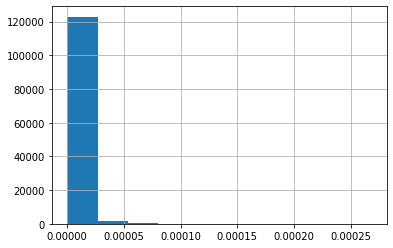

In [14]:
df.sort_values('probability', ascending=False, inplace=True)
df.probability.hist(bins=10)

In [15]:
ta = train_df.pronunciation.apply(lambda pronunciation: lm.calculate_probability(pronunciation))
da = dev_df.pronunciation.apply(lambda pronunciation: lm.calculate_probability(pronunciation))

In [16]:
ta.mean(), da.mean()

(2.212165525096426e-06, 2.1588918122259678e-06)

In [17]:
ta.describe()

count    9.874600e+04
mean     2.212166e-06
std      8.692212e-06
min      2.037810e-53
25%      1.315218e-10
50%      1.660605e-08
75%      7.058629e-07
max      2.683263e-04
Name: pronunciation, dtype: float64

In [18]:
da.describe()

count    2.500000e+04
mean     2.158892e-06
std      8.423432e-06
min      5.235376e-30
25%      1.216696e-10
50%      1.541063e-08
75%      6.804644e-07
max      2.683263e-04
Name: pronunciation, dtype: float64

In [ ]:
df[df.length == 3]

### Comparing Multiple Pronunciations ###

In [19]:
df[df.word == 'with'].sort_values('probability', ascending=False)

,word,pronunciation,phoneme_ids,pronunciation_string,length,probability
122549,with,"[W, IH1, TH]","[1, 58, 55, 18, 2]",W IH1 TH,3,6.770930e-06
122548,with,"[W, IH1, DH]","[1, 58, 55, 64, 2]",W IH1 DH,3,2.002014e-06
122550,with,"[W, IH0, TH]","[1, 58, 32, 18, 2]",W IH0 TH,3,1.672213e-09
122551,with,"[W, IH0, DH]","[1, 58, 32, 64, 2]",W IH0 DH,3,2.622104e-10


In [20]:
df[df.word == 'tomato'].sort_values('probability', ascending=False)

,word,pronunciation,phoneme_ids,pronunciation_string,length,probability
113135,tomato,"[T, AH0, M, AA1, T, OW2]","[1, 5, 3, 19, 10, 5, 30, 2]",T AH0 M AA1 T OW2,6,1.418219e-09
113134,tomato,"[T, AH0, M, EY1, T, OW2]","[1, 5, 3, 19, 4, 5, 30, 2]",T AH0 M EY1 T OW2,6,1.253598e-09


In [21]:
df[df.word=='pajamas'].sort_values('probability', ascending=False)

,word,pronunciation,phoneme_ids,pronunciation_string,length,probability
82275,pajamas,"[P, AH0, JH, AA1, M, AH0, Z]","[1, 8, 3, 54, 10, 19, 3, 26, 2]",P AH0 JH AA1 M AH0 Z,7,5.805999e-09
82276,pajamas,"[P, AH0, JH, AE1, M, AH0, Z]","[1, 8, 3, 54, 28, 19, 3, 26, 2]",P AH0 JH AE1 M AH0 Z,7,2.213560e-09


In [25]:
lm.calculate_probability(['P', 'R', 'IH1', 'F', 'S'])

8.897179071637183e-07

In [26]:
lm.calculate_probability(['P', 'R', 'IH1', 'F', 'Z'])

1.119641184264892e-07

In [33]:
lm.calculate_probability(['S', 'T', 'R', 'UW1', 'Z'])

4.764592283392434e-06

### GENERATE PRONUNCIATIONS ###

In [22]:
for _ in range(10):
    pronunciation = lm.generate(100, temperature=None)
    pronunciation_string = ' '.join(pronunciation)
    matches = df[df.pronunciation_string == pronunciation_string]
    
    print(pronunciation_string)
    if len(matches) > 0:
        print('\t', matches.iloc[0]['word'], len(matches), 'total')
    print()

B R AH1 T T IH0 NG

S T W UW1 Z

SH R EH1 F AH0 L

T AY1 K
	 tike 3 total

M AH0 N T IY1 L S

D R AE1 B L IY0

CH EY1 Z

B UW1 S M AH0 S

G AA1 L AH0 L AH0 M

Y UW1 CH IY0



### Probability of Next ###

In [ ]:
def probability_next(lm, pronunciation):
    

In [52]:
lm.calculate_probability(['S'])

4.4958147842437395e-05

In [54]:
encode_pronunciation(['S'], lm.phoneme_to_idx)

array([ 1, 16,  2])

In [55]:
lm

PhonemeLM(
  (embedding): Embedding(73, 20)
  (rnn): GRU(20, 10, batch_first=True)
  (linear): Linear(in_features=10, out_features=73, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

In [56]:
torch.save(lm, 'lm.pt')

### Play with Embeddings ###

In [48]:
def most_similar_phonemes(lm, embedding, topn=10):
    other_to_sim = {
        phoneme: cosine_similarity(lm.embedding_for(phoneme), embedding).item()
        for phoneme in phoneme_to_idx

    }

    for other_phoneme, similarity in sorted(other_to_sim.items(), key=lambda p: -p[1])[:topn]:
        if other_phoneme != phoneme:
            print(f'[{similarity:.3f}]\t{other_phoneme}')
        
most_similar_phonemes(lm, lm.embedding_for('DH'))

[1.000]	DH
[0.504]	OY1
[0.501]	B
[0.484]	W
[0.471]	UW1
[0.403]	AA1
[0.380]	V
[0.377]	N
[0.349]	OY2
[0.314]	ZH


In [39]:
embeddings = lm.embeddings
# embeddings = lm.embedding.weight.cpu().detach().numpy()
normed_embeddings = normalize(embeddings)

num_clusters = 15
kmeans = KMeans(num_clusters)
kmeans.fit(normed_embeddings)

grouped = defaultdict(set)
for idx, label in enumerate(kmeans.labels_):
    phoneme = lm.vocab[idx]
    grouped[label].add(phoneme)
grouped

defaultdict(set,
            {6: {'<PAD>', 'AA0', 'ER2', 'OY0', 'UH1', 'UH2'},
             3: {'<W>', 'M', 'SH', 'ZH'},
             9: {'</W>', 'AW1', 'IY2'},
             11: {'AH0', 'OW0'},
             0: {'AE1', 'AE2', 'AH1', 'AH2', 'EH1', 'EY1', 'IH1', 'IH2'},
             2: {'D', 'L', 'P', 'T', 'V'},
             8: {'G', 'JH', 'R', 'S', 'UW', 'W'},
             14: {'AA1', 'AY1', 'DH', 'N', 'OY1', 'UW1'},
             1: {'B', 'CH', 'F', 'TH'},
             12: {'AA2', 'AO0', 'AO1', 'AO2', 'AY0', 'AY2', 'ER0'},
             5: {'EY2', 'HH', 'K', 'OY2', 'UW2'},
             7: {'EH0', 'EY0', 'NG', 'Y', 'Z'},
             13: {'ER1', 'IY1', 'OW1', 'OW2'},
             10: {'AE0', 'AW0', 'AW2', 'EH2', 'IH0', 'IY0'},
             4: {'UH0', 'UW0'}})

In [34]:
# For consonants
# - voicing
# - place: bilabial, dental, alveolar, palatal, velar
# - manner: stop, fricative, nasal

# For vowels
# - front/back
# - closed/open
# - rounding

# General
# - syllabic

# TODO: combine multiple vectors together, e.g. {B, G, V, DH, D} for voiced
voicing = lm.embedding_for('B') - lm.embedding_for('P')
forwarding = lm.embedding_for('P') - lm.embedding_for('K')
frication = lm.embedding_for('F') - lm.embedding_for('P')

new = lm.embedding_for('TH') + voicing
# new = lm.embedding_for('K') + voicing
# new = lm.embedding_for('T') + frication
# new = lm.embedding_for('K') + forwarding

phoneme_to_sim = {}
for phoneme in phoneme_to_idx:
    this_embs = lm.embedding_for(phoneme)
    sim = cosine_similarity(new, this_embs).item()
    phoneme_to_sim[phoneme] = sim

sorted(phoneme_to_sim.items(), key=lambda p: -p[1])[:5]

[('B', 0.8937468528747559),
 ('TH', 0.5132555961608887),
 ('OW0', 0.4824915826320648),
 ('M', 0.4792366921901703),
 ('W', 0.4642067551612854)]

In [ ]:
import numpy as np
# np.mean([embedding_for('B'), embedding_for('V')], axis=0)
voiced = np.mean([lm.embedding_for(phoneme) for phoneme in ['B', 'V', 'G', 'Z', 'ZH', 'DH', 'JH']], axis=0)
voiceless = np.mean([lm.embedding_for(phoneme) for phoneme in ['P', 'F', 'K', 'S', 'SH', 'TH', 'CH']], axis=0)
voicing = voiced - voiceless
most_similar_phonemes(lm, voicing + lm.embedding_for('S'))

In [ ]:
most_similar_phonemes(lm, voicing)

In [38]:
from phoneme_lm import START, END, PAD
def analogy(lm, a, b, c):
    """
    a - b = c - w
    argmax(w) over sim(w, c - a + b)
    """
    emb_a = lm.embedding_for(a)
    emb_b = lm.embedding_for(b)
    emb_c = lm.embedding_for(c)
    
    all_phonemes = set(lm.vocab) - {START, END, PAD}
    
    phoneme_to_sim = {}
    for phoneme in all_phonemes:
        if phoneme in {a, b, c}:
            continue
        
        emb_p = lm.embedding_for(phoneme)
        sim = cosine_similarity(emb_p, emb_c - emb_a + emb_b)
        phoneme_to_sim[phoneme] = sim.item()
    return phoneme_to_sim

analogies = analogy(lm, 'P', 'K', 'B')
for phoneme, sim in sorted(analogies.items(), key=lambda p: -p[1]):
    print(f'[{sim:.4f}] {phoneme}')


[0.5136] OY2
[0.4900] HH
[0.4130] DH
[0.3729] M
[0.3076] F
[0.3002] AY2
[0.2979] AY0
[0.2893] UW
[0.2315] IY0
[0.2241] OY1
[0.2016] SH
[0.1831] G
[0.1444] TH
[0.1341] Y
[0.1280] OW1
[0.1185] W
[0.1154] EY2
[0.1103] UW2
[0.0917] S
[0.0903] NG
[0.0844] AW1
[0.0583] AY1
[0.0537] ZH
[0.0408] AH1
[0.0373] EH1
[0.0282] V
[0.0159] EY1
[0.0056] CH
[-0.0164] ER1
[-0.0231] AE2
[-0.0310] AA1
[-0.0311] AE0
[-0.0326] UW1
[-0.0358] OW2
[-0.0399] IH1
[-0.0404] AE1
[-0.0429] N
[-0.0523] UH1
[-0.0581] JH
[-0.0587] OW0
[-0.0692] IY2
[-0.0747] R
[-0.0947] T
[-0.1003] Z
[-0.1052] IH2
[-0.1224] AH2
[-0.1228] UH0
[-0.1380] EY0
[-0.1398] AO1
[-0.1418] AH0
[-0.1560] UW0
[-0.1603] AO2
[-0.1718] IY1
[-0.1850] AW2
[-0.1855] AA2
[-0.1923] AW0
[-0.2418] OY0
[-0.2444] L
[-0.2474] AO0
[-0.2531] EH2
[-0.3158] ER0
[-0.3345] UH2
[-0.4047] ER2
[-0.4093] AA0
[-0.4322] EH0
[-0.4421] IH0
[-0.4431] D


In [ ]:
embeddings.shape

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=3).fit_transform(embeddings)
tsne.shape